In [155]:
import functools
import time

import jax
import jax.numpy as jnp
import jax.random
import diffrax
import numpy as np
import matplotlib.pyplot as plt

jax.config.update("jax_enable_x64", True)

In [110]:
def plot_time_series(U,t, labels=None, t_lim = None, figsize = (20,8), **kwargs):
    '''
    Plots time series data with separate panels for each state variable.

    INPUTS:
        U: 2D array of shape (Nu, Nt) where Nu is the number of state variables and Nt is the number of time points
        t: 1D array of time points
        labels: list of strings containing the names of the state variables
        t_lim: limit for the x-axis
        **kwargs: additional arguments to pass to plot
    '''
    if t_lim is None:
        t_lim = t[-1]
    kwargs.setdefault('linewidth', 2)
    fig, axs = plt.subplots(U.shape[0], figsize = figsize)
    for i in range(U.shape[0]):
        axs[i].plot(t, U[i,:], **kwargs)
        axs[i].set_xlim([0,t_lim])
        if labels is not None:
            axs[i].set(ylabel=labels[i])
    axs[-1].set(xlabel=r't')
    plt.show()

def imshow_1D_spatiotemp(U, TN, domain=(0,1), figsize=(20, 6), title = None, **kwargs):
    '''
    Plot 1D spatiotemporal data using imshow. 
    Author: Dima Tretiak

    INPUTS:
        U: 2D array of shape (Nx, NT) where Nx is the number of spatial points and NT is the number of time points
        TN: final time
        domain: tuple of length 2 containing the bounds of the spatial domain
        title: string containing the title of the plot, if None no title is shown
        **kwargs: additional arguments to pass to imshow
    '''

    #set defaults for imshow
    kwargs.setdefault('aspect', 'auto')
    kwargs.setdefault('origin', 'lower')
    kwargs.setdefault('cmap', 'RdGy')
    kwargs.setdefault('extent', [0, TN, domain[0], domain[1]])

    plt.figure(figsize=figsize, dpi=300)
    plt.imshow(U, **kwargs)
    plt.ylabel('x')
    plt.xlabel('t')
    if title is not None:
        plt.title(title)
    plt.colorbar(pad = 0.01, label = r'$u$')
    plt.show()
    
# TODO: Plot attractor, imshow 1d spatiotemp, edit above to use U list 

# systems to implement:
- "basic"
    - lorenz63
    - rossler  
    - sakaraya 
    - colpitts
- hamiltonian
    - double pendulum 
- PDE
    - KS
    - lorenz96

# basic

In [ ]:
### Lorenz
def lorenz63_f(t,y, args):
    rho, sigma, beta = args
    y1, y2, y3 = y
    dy1dt = sigma*(y2 - y1)
    dy2dt = y1*(rho - y3) - y2
    dy3dt = y1*y2 - beta*y3
    dydt = dy1dt, dy2dt, dy3dt
    return jnp.array(dydt)

TN = 20
term = diffrax.ODETerm(lorenz63_f)
solver = diffrax.Tsit5()
saveat = diffrax.SaveAt(ts=jnp.linspace(0, TN, 1000))
args = 28.0, 10.0, 8.0/3.0
sol = diffrax.diffeqsolve(term, solver, 0, TN, y0 = jnp.array([1,1,1]), dt0 = 0.1, saveat=saveat, args=args)


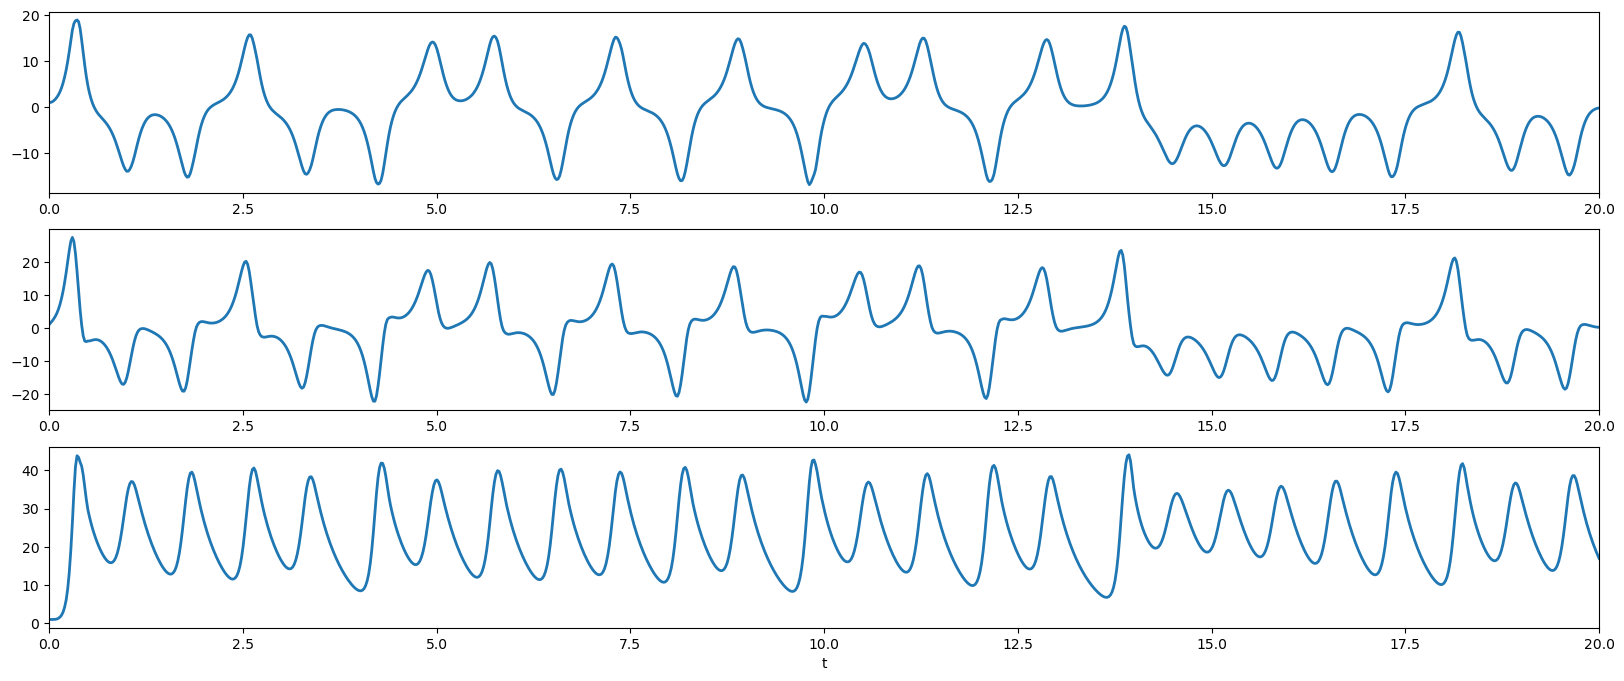

In [ ]:
plot_time_series(sol.ys.T, sol.ts)

In [80]:
### Rossler 
@jax.jit
def rossler_f(t,y, args):
    a,b,c = args
    y1, y2, y3 = y
    dy1dt = -y2 - y3
    dy2dt = y1 + a*y2
    dy3dt = b+y3*(y1-c)
    dydt = dy1dt, dy2dt, dy3dt
    return jnp.array(dydt)

TN = 100
term = diffrax.ODETerm(rossler_f)
solver = diffrax.Tsit5()
saveat = diffrax.SaveAt(ts=jnp.linspace(0, TN, 1000))
args = 0.1, 0.1, 14
sol = diffrax.diffeqsolve(term, solver, 0, TN, y0 = jnp.array([1,1,1]), dt0 = 0.1, saveat=saveat, args=args)

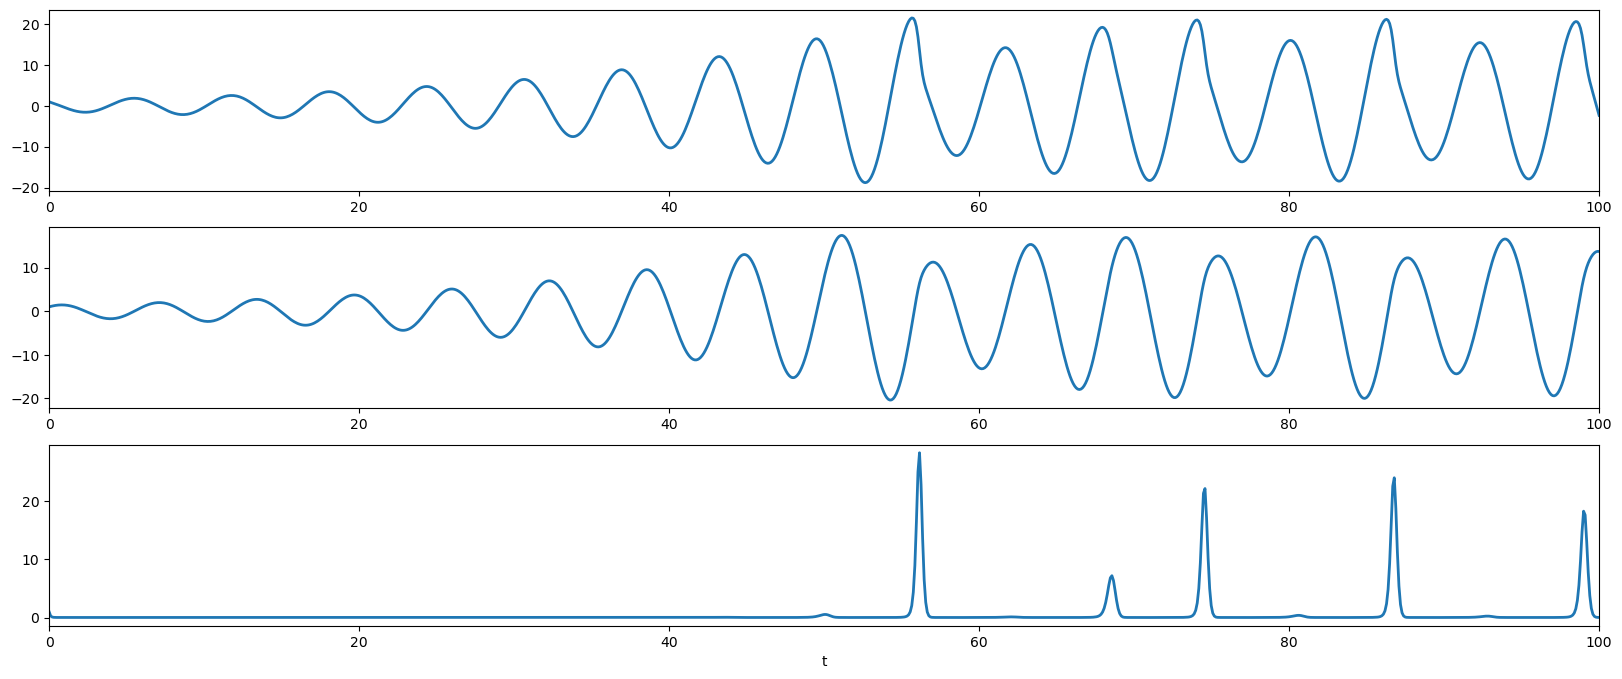

In [ ]:
plot_time_series(sol.ys.T, sol.ts)

In [91]:
### Double Pendulum 
@jax.jit
def double_pendulum_f(t, y, args):
    a, b, m = args
    y1, y2, y3 = y

    dy1dt = a * y1 + y2 + y2*y3
    dy2dt = -y1*y3 + y2*y3
    dy3dt = -y3 - m*y1*y2 + b

    return jnp.array([dy1dt, dy2dt, dy3dt])

TN = 40
term = diffrax.ODETerm(double_pendulum_f)
solver = diffrax.Tsit5()
saveat = diffrax.SaveAt(ts=jnp.linspace(0, TN, 1000))
y0 = jnp.array([-2.8976045, 3.8877978, 3.07465])
args = 1,1,1 # a, m, b 
sol = diffrax.diffeqsolve(term, solver, 0, TN, y0 = y0, dt0 = 0.1, saveat=saveat, args=args)

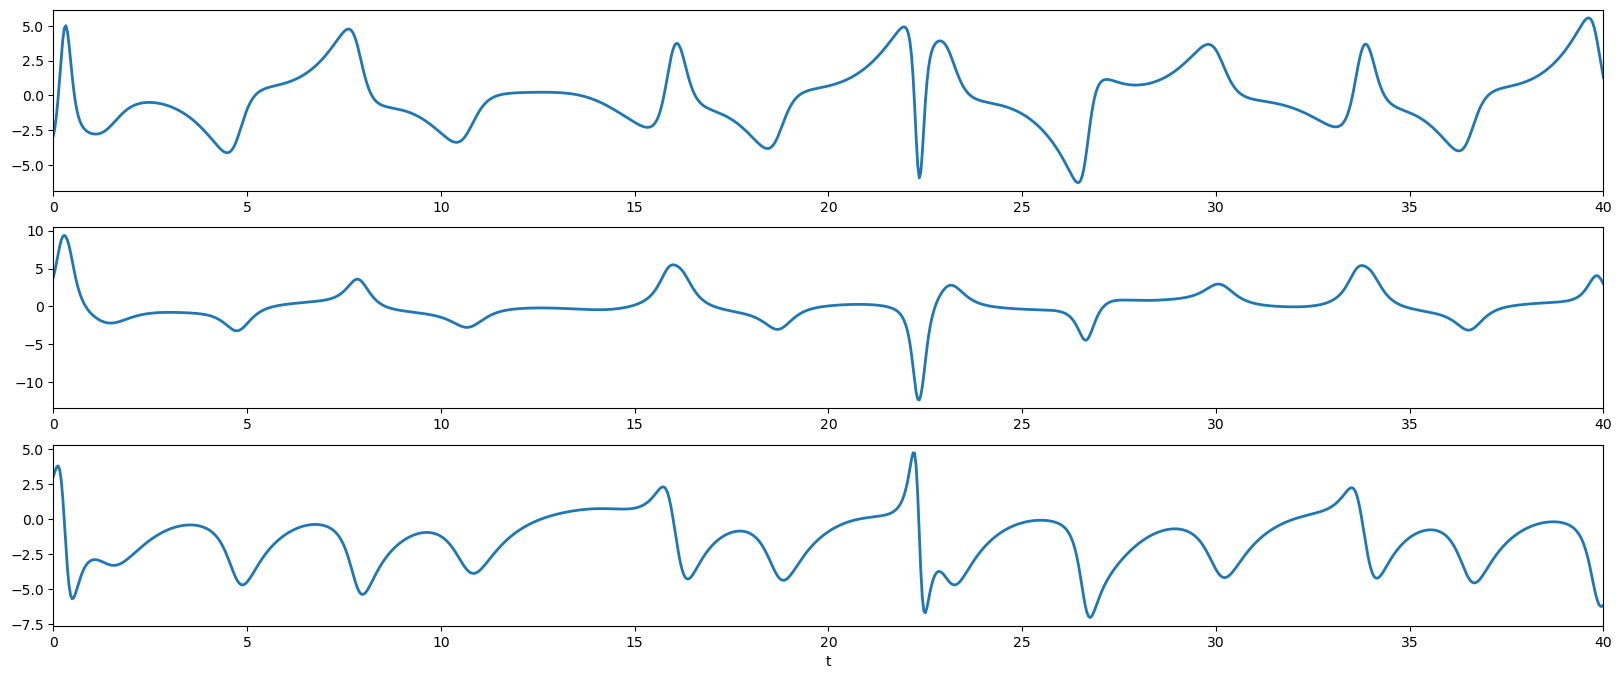

In [92]:
plot_time_series(sol.ys.T, sol.ts)

# Hamiltonian 

In [ ]:
### Double Pendulum 
@jax.jit
def double_pendulum_f(t, y, args):
    m1, m2, L1, L2, g, damping = args
    theta1, omega1, theta2, omega2 = y

    #define some vars to shorten the expressions
    delta_theta = theta1 - theta2
    M_tot = m1 + m2
    alpha = m1 + m2*jnp.sin(delta_theta)**2

    # compute derivs
    dtheta1_dt = omega1
    dtheta2_dt = omega2
    domega1_dt = (-jnp.sin(delta_theta) * (m2*L1*omega1**2*jnp.cos(delta_theta) + m2*L2*omega2**2) - g*(M_tot * jnp.sin(theta1) - m2*jnp.sin(theta2)*jnp.cos(delta_theta))) / (L1*alpha) - damping*(omega1-omega2) - damping*omega1
    domega2_dt = (jnp.sin(delta_theta) *(M_tot*L1*omega1**2 + m2*L2*omega2**2*jnp.cos(delta_theta)) + g*(M_tot*jnp.sin(theta1)*jnp.cos(delta_theta) - M_tot*jnp.sin(theta2))) / (L2*alpha) - damping*(omega2-omega1)

    return jnp.array([dtheta1_dt, domega1_dt, dtheta2_dt, domega2_dt])

TN = 20
term = diffrax.ODETerm(double_pendulum_f)
solver = diffrax.Tsit5()
saveat = diffrax.SaveAt(ts=jnp.linspace(0, TN, 1000))
args = 1.0, 1.0, 1.0, 1.0, 9.81, 0.0 # m1, m2, L1, L2, g, c
sol = diffrax.diffeqsolve(term, solver, 0, TN, y0 = jnp.array([1,1,1,1]), dt0 = 0.1, saveat=saveat, args=args)

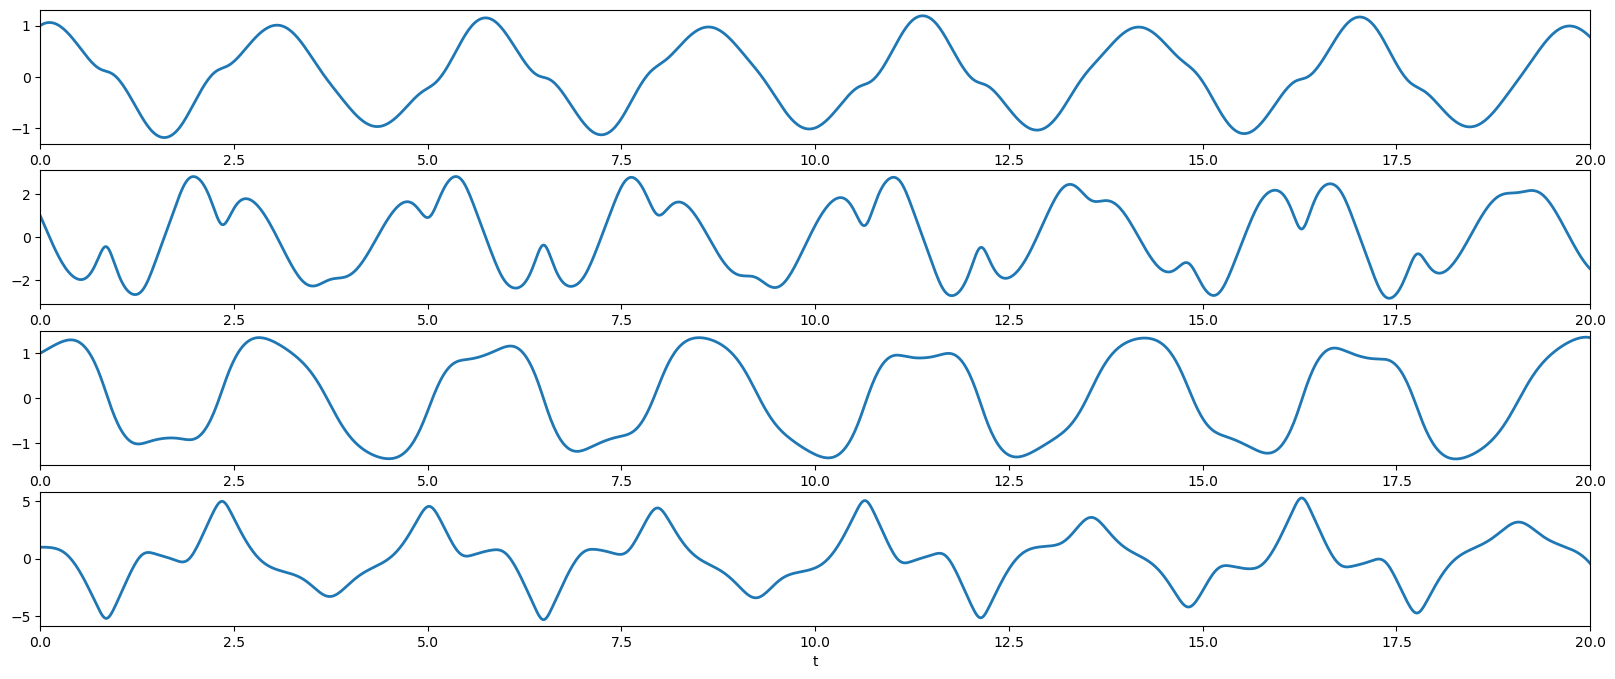

In [ ]:
plot_time_series(sol.ys.T, sol.ts)

# High dim systems 

In [147]:
### Lorenz96
def lorenz96_f(t,y,args):
    N, F = args
    dydt = jnp.zeros(N)

    # boundary at N
    dydt = dydt.at[N-1].set((y[0] - y[N-3])*y[N-2]-y[N-1] + F)
    for i in range(N-1):
        dydt = dydt.at[i].set((y[i+1] - y[i-2])*y[i-1]-y[i] + F)
    return jnp.array(dydt)

TN = 20
N = 200
F = 8.0
term = diffrax.ODETerm(lorenz96_f)
solver = diffrax.Tsit5()
saveat = diffrax.SaveAt(ts=jnp.linspace(0, TN, 1000))
args = N, F
key = jax.random.PRNGKey(0)
y0 = jax.random.normal(key, N)
sol = diffrax.diffeqsolve(term, solver, 0, TN, y0 = y0, dt0 = 0.1, saveat=saveat, args=args)

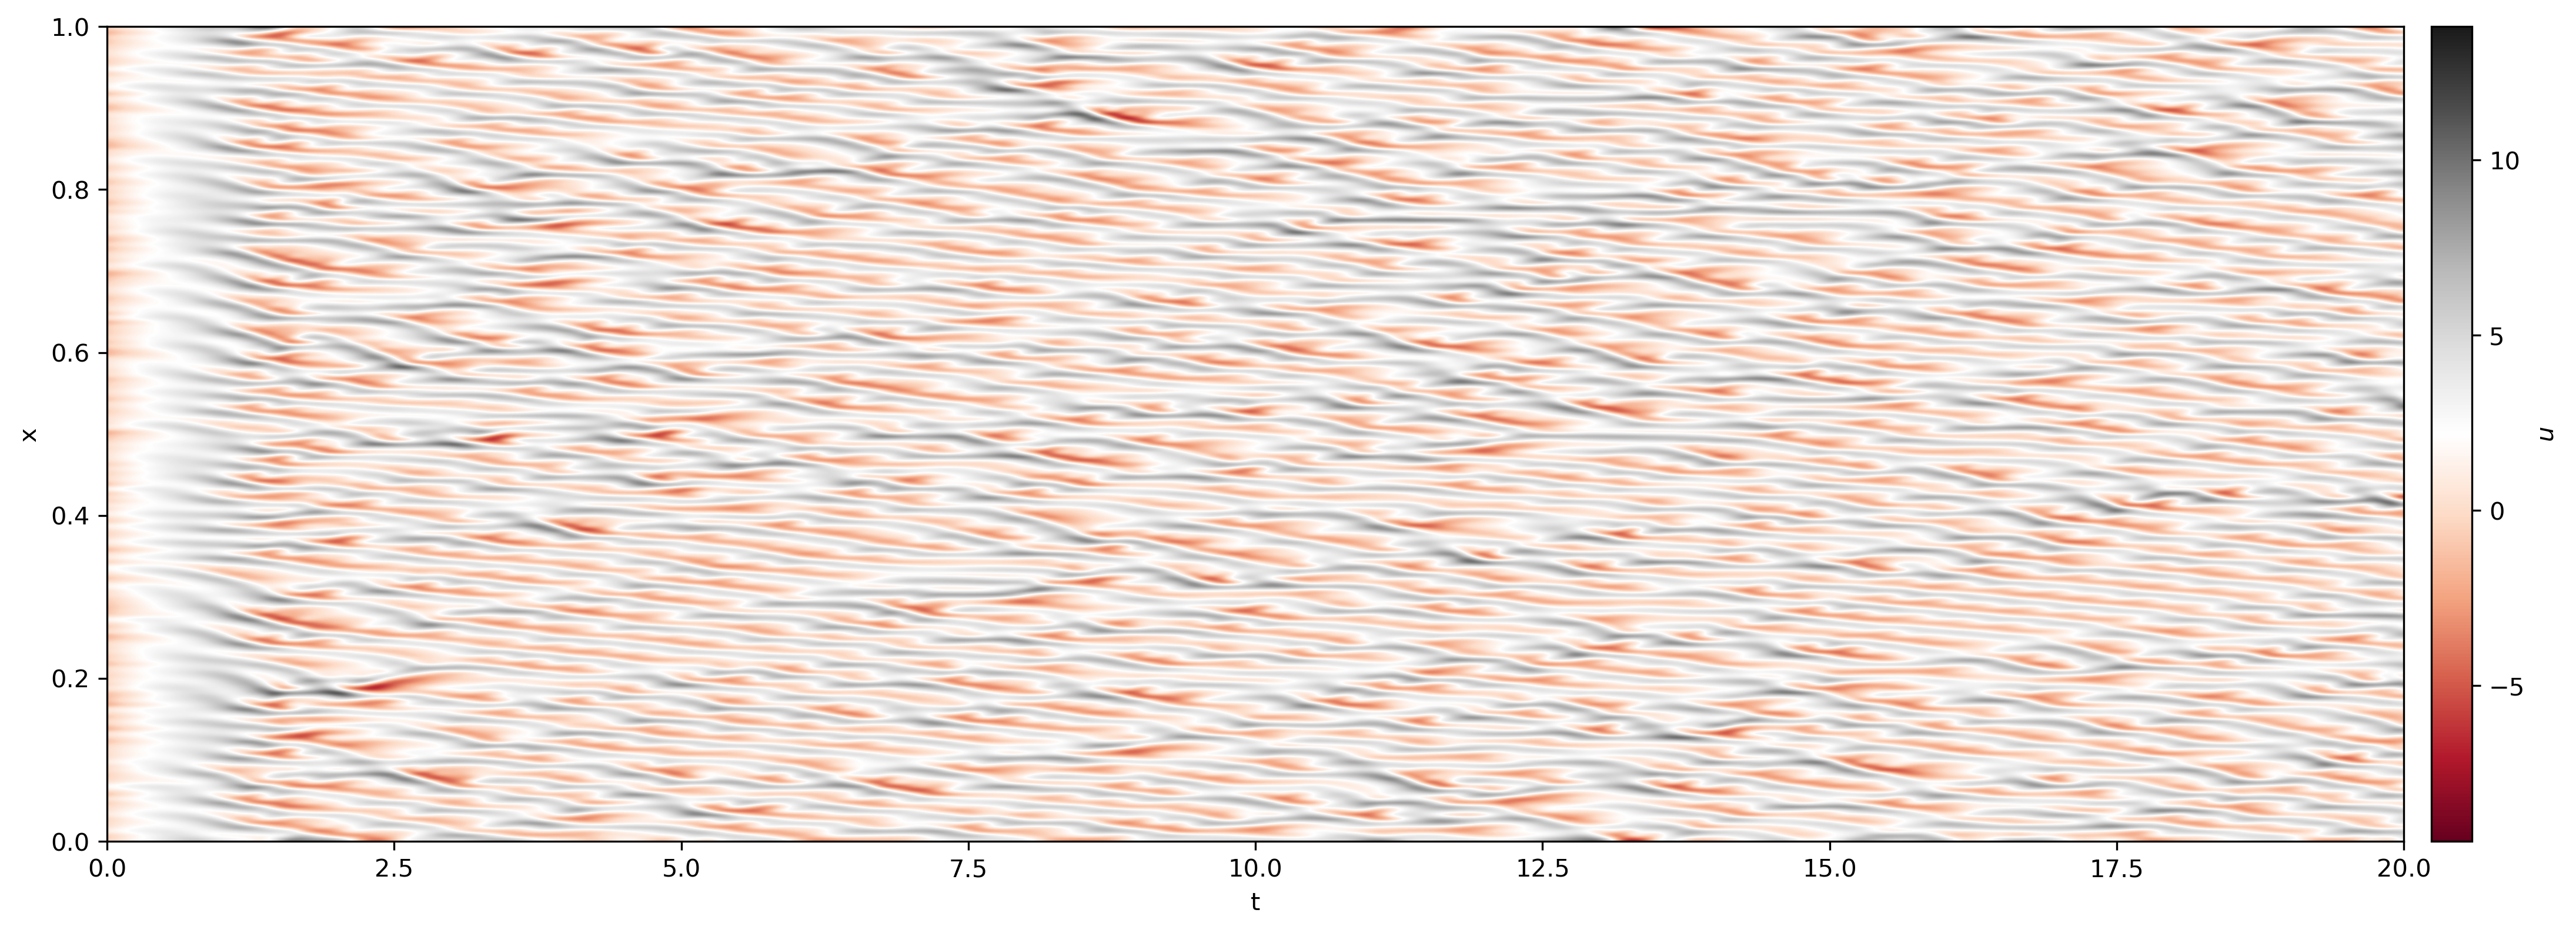

In [148]:
imshow_1D_spatiotemp(sol.ys.T, sol.ts[-1], interpolation = 'bicubic')

In [149]:
### Lorenz96 with vmap 
@jax.jit
def _loren96_interior(i,y,F):
    return (y[i+1] - y[i-2])*y[i-1]-y[i] + F

@functools.partial(jax.jit, static_argnames=["args"])
def lorenz96_vmap_f(t,y,args):
    N, F = args

    # boundary at N
    dydt_N = (y[0] - y[N-3])*y[N-2]-y[N-1] + F

    # calculate all other points (interior plus boundary at 0)
    dydt_func = jax.vmap(_loren96_interior, in_axes=(0,None,None))
    interior_idxs = jnp.arange(N-1)
    dydt_interior = dydt_func(interior_idxs, y, F)

    return jnp.append(dydt_interior, dydt_N)

TN = 20
N = 200
F = 8.0
term = diffrax.ODETerm(lorenz96_vmap_f)
solver = diffrax.Tsit5()
saveat = diffrax.SaveAt(ts=jnp.linspace(0, TN, 1000))
args = N, F
key = jax.random.PRNGKey(0)
y0 = jax.random.normal(key, N)
sol = diffrax.diffeqsolve(term, solver, 0, TN, y0 = y0, dt0 = 0.1, saveat=saveat, args=args)

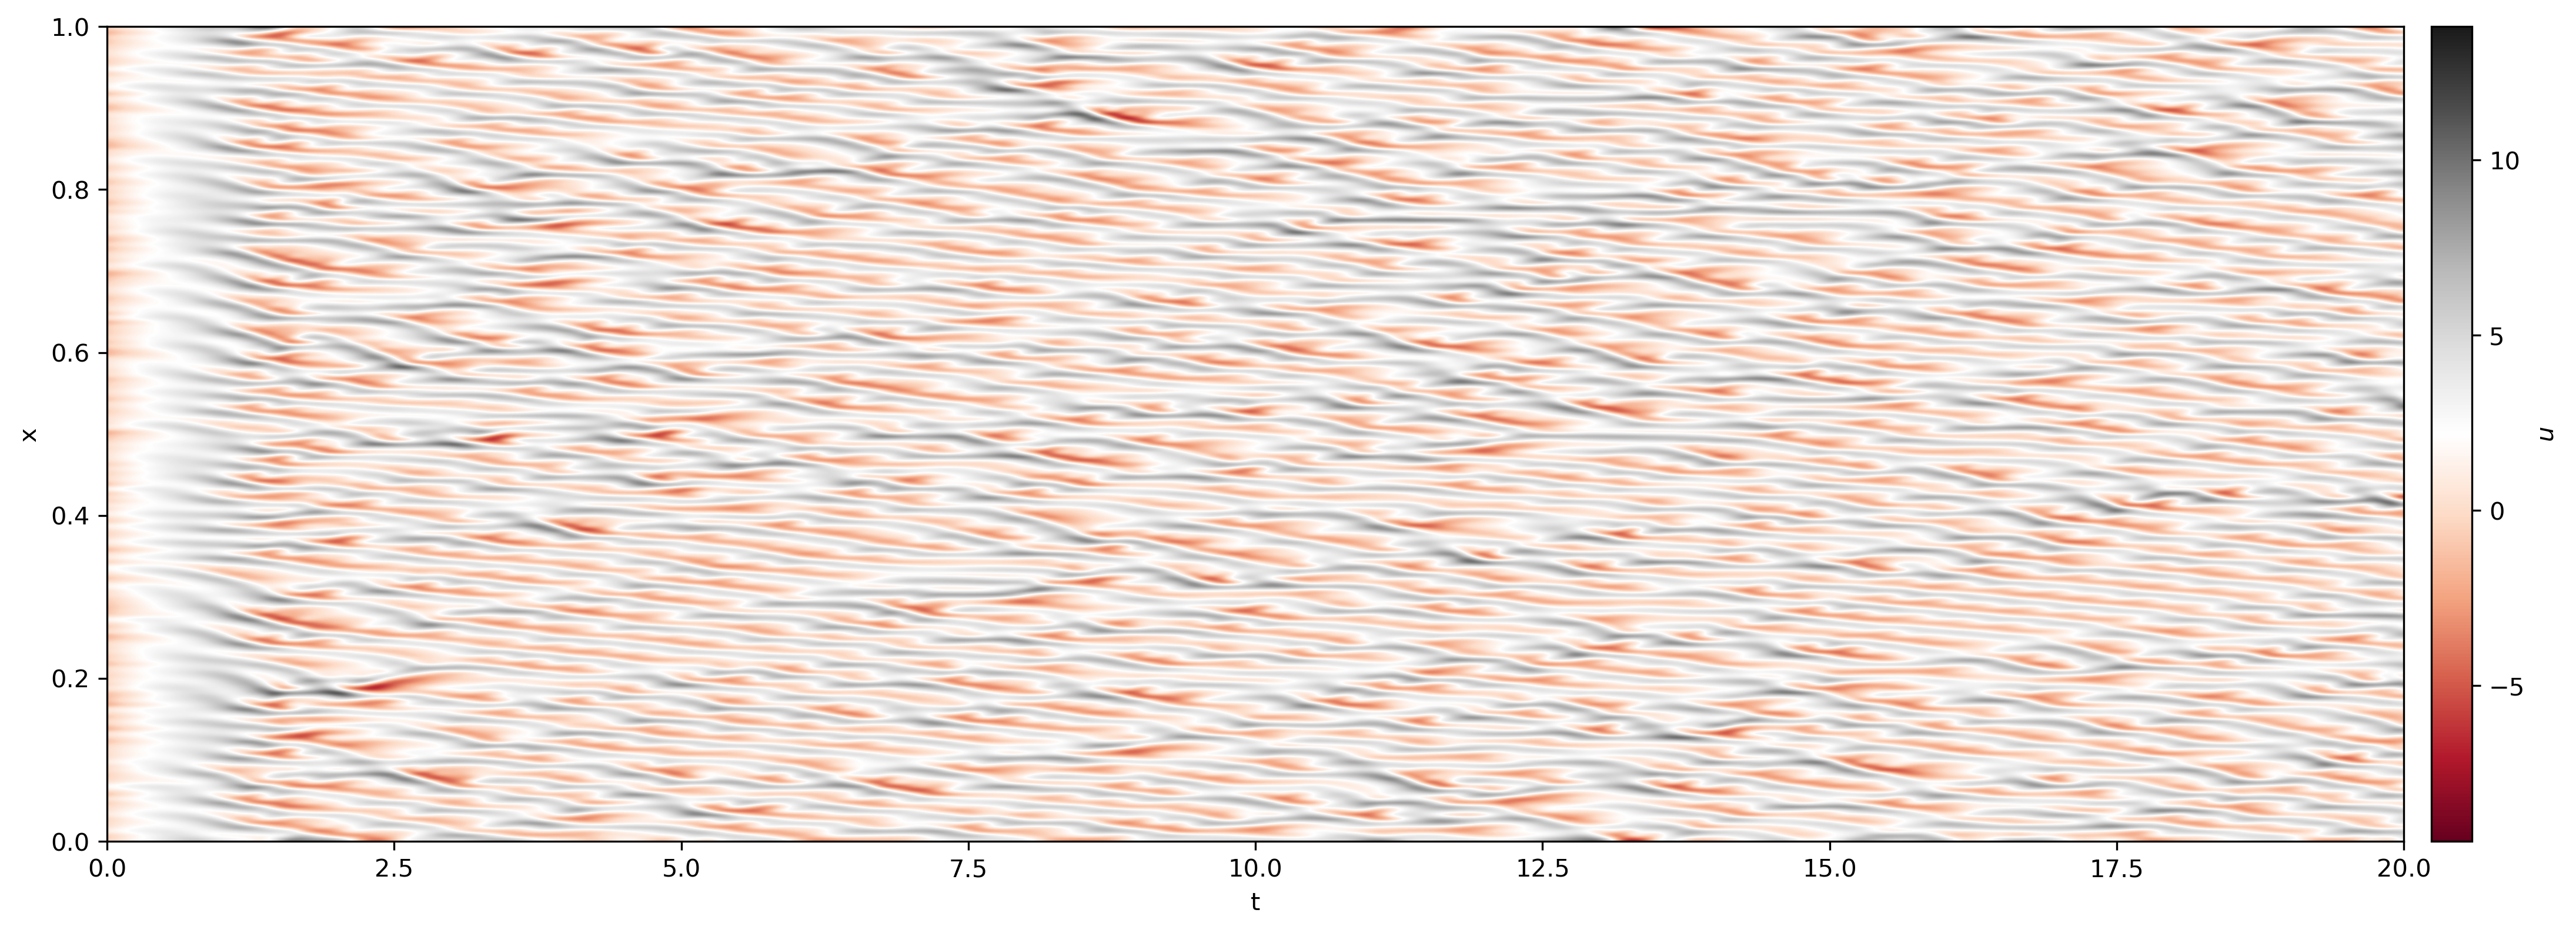

In [150]:
imshow_1D_spatiotemp(sol.ys.T, sol.ts[-1], interpolation = 'bicubic')

In [164]:
### lorenz timing comparisons
n_trials = 10
TN = 100
N = 1000
F = 8.0

# universal params
solver = diffrax.Tsit5()
saveat = diffrax.SaveAt(ts=jnp.linspace(0, TN, 1000))
args = N, F
key = jax.random.PRNGKey(0)
y0 = jax.random.normal(key, N)

times = []
terms = [diffrax.ODETerm(lorenz96_f), diffrax.ODETerm(lorenz96_vmap_f)]

for term in terms:
    start_t = time.time()
    for _ in range(n_trials):
        sol = diffrax.diffeqsolve(term, solver, 0, TN, y0 = y0, dt0 = 0.1, saveat=saveat, args=args)
        sol.ys.block_until_ready()
    times.append((time.time()-start_t)/n_trials)

print(times)

[0.30245389938354494, 0.021212053298950196]
